## Inference for SVD after GridSearch

Uses the grid object to make predictions using the best algo configuration found by the GridSearch. 
Separate notebook for inference since running the GridSearch takes about 5 hours, so we just load back in the pickled grid object containing the best predictor.

In [1]:
import pickle
import surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import random

In [2]:
userID2userNameMap = {}
userName2userIDMap = {}

animeID2animeNameMap = {}
animeName2animeIDMap = {}

with open('userName2userIDMap.pkl', 'rb') as f:
    userName2userIDMap = pickle.load(f)

with open('userID2userNameMap.pkl', 'rb') as f:
    userID2userNameMap = pickle.load(f)


with open('animeID2animeNameMap.pkl', 'rb') as f:
    animeID2animeNameMap = pickle.load(f)

with open('animeName2animeIDMap.pkl', 'rb') as f:
    animeName2animeIDMap = pickle.load(f)

In [3]:
df = None
with open('df_custom.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
user_ids = None
with open('user_ids.pkl', 'rb') as f:
    user_ids = pickle.load(f)

In [5]:
# the largest thing to open back up
with open('grid.pkl', 'rb') as f:
    grid = pickle.load(f)

In [6]:
def get_top_n_recommendations(algo : surprise.model_selection.search.GridSearchCV, user_id : int, n : int=10):
    # Get anime_ids that the user has NOT rated
    tmp = df[df['user_id'] == user_id]
    rated_anime_ids = tmp['anime_id']
    all_anime_ids = pd.Series(data=df['anime_id'].unique())
    not_rated_anime_ids = all_anime_ids[~all_anime_ids.isin(rated_anime_ids)]

    # print(f'user {user_id} has rated {len(rated_anime_ids)} anime')
    # print(f'so they have not rated: {len(not_rated_anime_ids)}')
    
    # Predict ratings for all anime the user hasn't rated
    user_id = str(user_id)
    predictions = [algo.predict(user_id, anime_id) for anime_id in not_rated_anime_ids]
    
    # Sort the predictions in descending order of the estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Return the top N anime_ids
    top_n_anime_ids = [pred.iid for pred in predictions[:n]]
    return top_n_anime_ids


In [7]:
unique_user_ids = list(set(user_ids))

In [8]:
for test_user_id in random.choices(unique_user_ids, k=5):
    top_recommendations = get_top_n_recommendations(algo=grid, user_id=test_user_id, n=5)
    print(f"Recommendations for {userID2userNameMap[test_user_id]}: ")
    for rec in top_recommendations:
        print('\t' + animeID2animeNameMap[rec])
    print()

Recommendations for bankai_wolf: 
	Death Note
	Howl no Ugoku Shiro
	Kimi no Na wa.
	Dragon Ball Z
	Code Geass: Hangyaku no Lelouch R2

Recommendations for ErikkuSenpai: 
	Death Note
	Howl no Ugoku Shiro
	Kimi no Na wa.
	Mononoke Hime
	Dragon Ball Z

Recommendations for drugster88: 
	Kimi no Na wa.
	One Punch Man
	Mononoke Hime
	Dragon Ball Z
	Code Geass: Hangyaku no Lelouch R2

Recommendations for CeeJaii: 
	Sen to Chihiro no Kamikakushi
	Howl no Ugoku Shiro
	Kimi no Na wa.
	Mononoke Hime
	Code Geass: Hangyaku no Lelouch R2

Recommendations for kozkii: 
	One Punch Man
	Dragon Ball Z
	Code Geass: Hangyaku no Lelouch R2
	Final Fantasy VII: Advent Children
	Code Geass: Hangyaku no Lelouch



In [9]:
grid.param_combinations

[{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02},
 {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.03},
 {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.02},
 {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.03},
 {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02},
 {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.03},
 {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.001, 'reg_all': 0.02},
 {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.001, 'reg_all': 0.03},
 {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02},
 {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.03},
 {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.02},
 {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.03},
 {'n_factors': 200, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02},
 {'n_factors': 200, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.03},
 {'n_f

In [10]:
import matplotlib.pyplot as plt

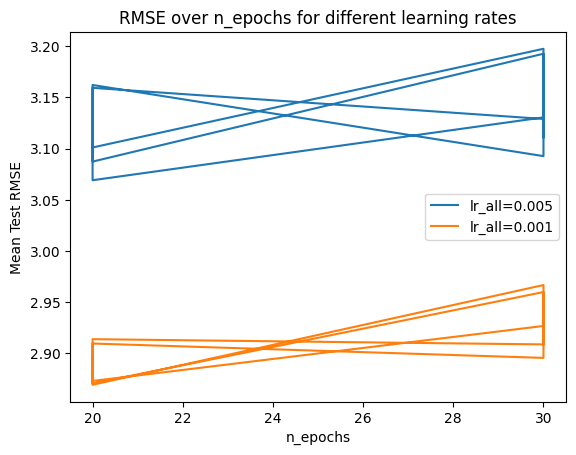

In [11]:
# Convert the results to a DataFrame
results_df = pd.DataFrame.from_dict(grid.cv_results)

# Assuming you were tuning 'n_epochs' and 'lr_all'
for lr_all in results_df['param_lr_all'].unique():
    subset = results_df[results_df['param_lr_all'] == lr_all]
    plt.plot(subset['param_n_epochs'], subset['mean_test_rmse'], label=f'lr_all={lr_all}')

plt.xlabel('n_epochs')
plt.ylabel('Mean Test RMSE')
plt.legend()
plt.title('RMSE over n_epochs for different learning rates')
plt.show()

In [12]:
# what is the best configuration?
grid.best_params

{'rmse': {'n_factors': 300, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.03},
 'mae': {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.03}}

In [13]:
grid.best_score

{'rmse': 2.8689316031185306, 'mae': 2.222182058129826}

In [14]:
grid.cv_results

{'split0_test_rmse': array([3.10506141, 3.07047766, 2.8981944 , 2.87378598, 3.13230614,
        3.09360585, 2.92786911, 2.89633865, 3.16307528, 3.10164798,
        2.90992517, 2.87099091, 3.19789147, 3.13047438, 2.96103397,
        2.90879428, 3.16097129, 3.08801719, 2.91483916, 2.86925125,
        3.19401438, 3.11169819, 2.96771437, 2.90855387]),
 'split1_test_rmse': array([3.10130517, 3.06821863, 2.89574624, 2.87208446, 3.12925974,
        3.09278693, 2.92486555, 2.89470073, 3.16033312, 3.09963493,
        2.90851569, 2.86975384, 3.19862933, 3.12692101, 2.95837449,
        2.90832721, 3.1572627 , 3.08615183, 2.91353731, 2.86798571,
        3.1916815 , 3.11028832, 2.96557128, 2.90773151]),
 'split2_test_rmse': array([3.10245042, 3.06790056, 2.8965338 , 2.87281096, 3.12995064,
        3.09215582, 2.92612544, 2.89448758, 3.16297782, 3.10190161,
        2.90922833, 2.86963815, 3.19598141, 3.1293762 , 2.95895247,
        2.9076277 , 3.15986978, 3.08669795, 2.9121713 , 2.86858203,
        